# Challenge 2
Signal in colored, Gaussian noise.

* Use the data file "challenge2.gwf", with channel name "H1:CHALLENGE2"
* The data contain a BBH signal with m1=m2=30 solar masses, spin = 0.




## Install and load data
Install the necessary software:


In [ ]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
! pip install matplotlib==3.1.3


     |████████████████████████████████| 46.2 MB 115 kB/s 
     |████████████████████████████████| 1.4 MB 39.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 6.0 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 295 kB 54.7 MB/s 
     |████████████████████████████████| 3.6 MB 46.7 MB/s 
     |████████████████████████████████| 1.4 MB 7.4 MB/s 
     |████████████████████████████████| 11.2 MB 35.6 MB/s 
     |████████████████████████████████| 895 kB 44.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 6.7 MB 7.2 MB/s 
     |████████████████

Load the data into memory:


In [ ]:
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf

from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")


--2022-02-15 02:12:18--  https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025842 (3.8M)
Saving to: ‘challenge2.gwf’

challenge2.gwf      100%[===================>]   3.84M  2.96MB/s    in 1.3s    

2022-02-15 02:12:19 (2.96 MB/s) - ‘challenge2.gwf’ saved [4025842/4025842]



What does it look like:

TimeSeries([ 8.75332715e-22,  1.27597248e-22,  1.88838802e-22,
            ..., -1.91886478e-23, -2.10989354e-22,
             2.30287965e-22]
           unit: ct,
           t0: -64.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE2,
           channel: H1:CHALLENGE2)


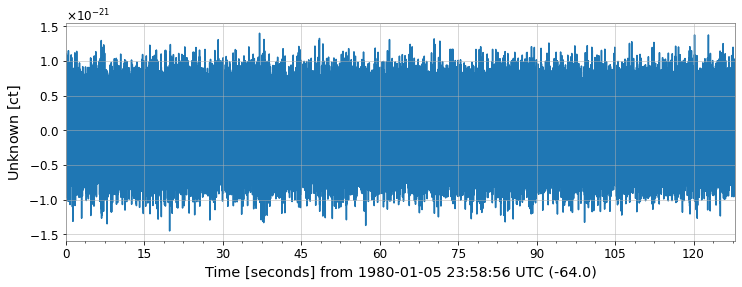

In [ ]:
print(gwpy_strain)
plot = gwpy_strain.plot()


In [ ]:
samplerate = gwpy_strain.sample_rate
print(samplerate)

4096.0 Hz


## Question 1
What is the approximative time of the merger? (Hint: a plot of the q-transform could help)


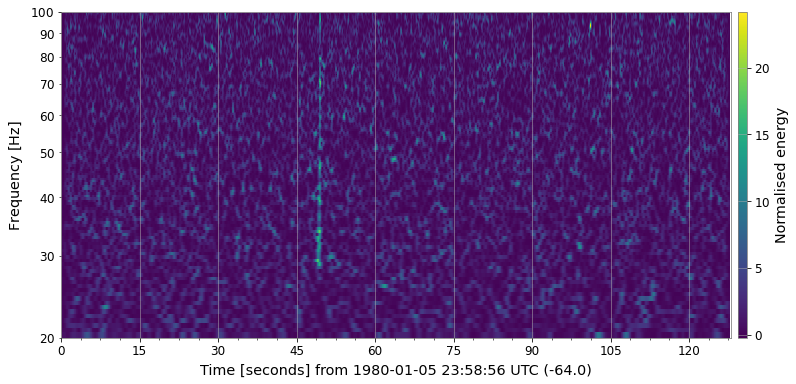

In [ ]:
q_transform = gwpy_strain.q_transform(frange = (20, 100), qrange = (100, 120))
plot = q_transform.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")



the approximate time of the merger is at 50 seconds

## Question 2
Generate a time-domain template waveform using approximate "SEOBNRv4_opt". with the same parameters as above. Plot this waveform.


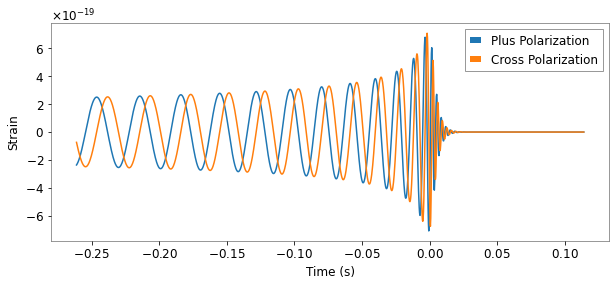

In [ ]:
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/4096,
                         f_lower=30,
                         spin = 0)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

## Question 3
Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging from 20 Hz up to the Nyquist frequency.


Nyquist frequency =  2048.0 Hz


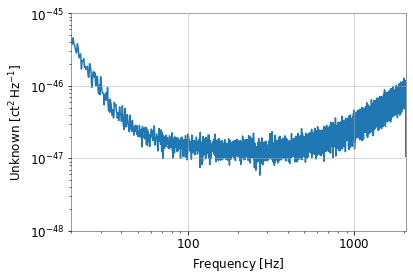

In [ ]:
psd = gwpy_strain.psd(4)

Nyquist_frequency = samplerate*0.5
print("Nyquist frequency = ", Nyquist_frequency)

plot = psd.plot()
ax = plot.gca()
ax.set_xlim(20, 2048)
ax.set_ylim(1e-48, 1e-45)
ax.set_yscale('log')
ax.set_xscale('log')

##Question 4
Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.

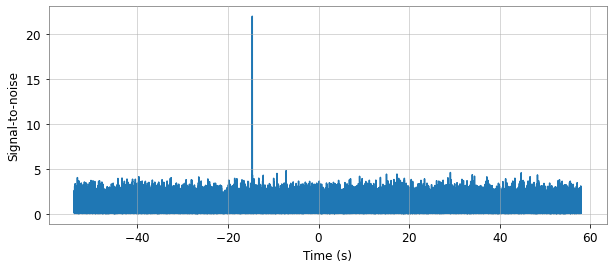

In [ ]:
import numpy
from pycbc import frame
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')
conditioned = strain.crop(2, 2)

hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=20)

snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()


## Question 5
What is the matched filter SNR of the signal?

In [ ]:
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

We found a signal at -14.6328125s with SNR 22.030671907548317
